# Imports

In [4]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt

# Activity 1

## 1.1 Sub-activity: Open Data API

### Task1

In [9]:
#To get the API: I find at https://ukhsa-dashboard.data.gov.uk/access-our-data/data-structure
# https://ukhsa-dashboard.data.gov.uk/access-our-data/examples
# https://ukhsa-dashboard.data.gov.uk/access-our-data/examples-api-pagination

def get_API_data(url):
    data = []
    while url:
        response = requests.get(url, params={"page_size": 365})
        if not response.ok:
            raise Exception("Error, request failed.")
        response_data = response.json()
        results = response_data["results"]
        next_url = response_data["next"]
        data.extend(results)
        url = next_url
    return data

### Task2

In [12]:
def fit_data(data, structure): # To import the data
    fit_data = []
    for item in data:
        transform_item = {}
        for key, value in structure.items():
            transform_item[key] = item.get(value, None)
        fit_data.append(transform_item)
    return fit_data

def append_data(data1, data2, key="date"): # Sinece in the National Part, the colums be divided in two parts: cases and deaths, so this function is to combine them
    append_data = []
    data2_dict = {item[key]: item for item in data2}
    for item in data1:
        append_item = item.copy()
        another_item = data2_dict.get(item[key])
        if another_item:
            append_item.update(another_item)
        append_data.append(append_item)
    return append_data

def save_to_json(data, filename):
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)

#Nationl json

national_API_cases = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_cases_casesByDay"
national_API_deaths = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_deaths_ONSByDay"

national_cases = {
    "Region": "geography",
    "date": "date",
    "daily_cases": "metric_value"
}

national_deaths = {
    "date": "date",
    "daily_deaths": "metric_value"
}

raw_cases_data = get_API_data(national_API_cases)
raw_deaths_data = get_API_data(national_API_deaths)

only_cases = fit_data(raw_cases_data, national_cases)
only_deaths = fit_data(raw_deaths_data, national_deaths)


nationl_full_data = append_data(only_cases, only_deaths)

save_to_json(nationl_full_data, "results_json_england.json")

# Regional json
base_regional_url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Government%20Office%20Region/geographies/{region}/metrics/COVID-19_deaths_ONSByDay"
#impport diffenrent regions
regions = ["East Midlands", "East of England", "London", "North East", 
           "North West", "South East", "South West", "West Midlands", "Yorkshire and The Humber"]

regional = {
    "Region":"geography",
    "date": "date",
    "daily_deaths": "metric_value"
}

all_regional_data = []

for region in regions:
    api_url = base_regional_url.format(region=region)
    raw_data = get_API_data(api_url)
    separate_data = fit_data(raw_data, regional)
    all_regional_data.extend(separate_data)


save_to_json(all_regional_data, "results_json_regional.json")

##  1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task3

In [15]:
regions_df = pd.DataFrame(all_regional_data)  
england_df = pd.DataFrame(nationl_full_data) 

### Task4

In [17]:
#  I already set the column names at Task1 (regional ={})

### Task5

In [19]:
regions_df["date"] = pd.to_datetime(regions_df["date"])
england_df["date"] = pd.to_datetime(england_df["date"])
#test
#print(regions_df.dtypes)

### Task6

In [21]:
# Print a summary of the dataframe
# Search :How to get the missing data in dataframe https://www.datacamp.com/tutorial/python-nan-missing-values-in-python

# Regional Data
print(regions_df.info(),"\n")
missing_data_r = regions_df.isnull().sum()
print("The amount of missing data is:")
print(missing_data_r,"\n")

# National Data
print(england_df.info(),"\n")
missing_data_n = england_df.isnull().sum()
print("The amount of missing data is:")
print(missing_data_n,"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12996 entries, 0 to 12995
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Region        12996 non-null  object        
 1   date          12996 non-null  datetime64[ns]
 2   daily_deaths  12996 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 304.7+ KB
None 

The amount of missing data is:
Region          0
date            0
daily_deaths    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Region        1778 non-null   object        
 1   date          1778 non-null   datetime64[ns]
 2   daily_cases   1778 non-null   float64       
 3   daily_deaths  1444 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory 

### Task7

In [23]:
# Remove missing from the england dataframe.
england_dfv2 = england_df.dropna(subset = ["daily_deaths"], inplace=False).copy() #.copy to avoid change the original data

print("DataFrame after cleaning：")
print(england_dfv2.info(),"\n")

DataFrame after cleaning：
<class 'pandas.core.frame.DataFrame'>
Index: 1444 entries, 0 to 1443
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Region        1444 non-null   object        
 1   date          1444 non-null   datetime64[ns]
 2   daily_cases   1444 non-null   float64       
 3   daily_deaths  1444 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 56.4+ KB
None 



### Task8

In [25]:
#Rolling averages
#To learn how to calculate the rolling mean: https://www.statology.org/rolling-mean-pandas/
england_dfv2 = england_df.dropna(subset = ["daily_deaths"], inplace=False).copy()
england_dfv2["daily_cases_roll_avg"] = england_dfv2["daily_cases"].rolling(7).mean()
england_dfv2["daily_deaths_roll_avg"] = england_dfv2["daily_deaths"].rolling(7).mean()

#Test
print(england_dfv2.head(15))

     Region       date  daily_cases  daily_deaths  daily_cases_roll_avg  \
0   England 2020-01-30          1.0           1.0                   NaN   
1   England 2020-01-31          0.0           0.0                   NaN   
2   England 2020-02-01          0.0           0.0                   NaN   
3   England 2020-02-02          1.0           1.0                   NaN   
4   England 2020-02-03         18.0           0.0                   NaN   
5   England 2020-02-04          0.0           0.0                   NaN   
6   England 2020-02-05          1.0           0.0              3.000000   
7   England 2020-02-06          0.0           0.0              2.857143   
8   England 2020-02-07          0.0           0.0              2.857143   
9   England 2020-02-08          3.0           0.0              3.285714   
10  England 2020-02-09          1.0           0.0              3.285714   
11  England 2020-02-10          1.0           0.0              0.857143   
12  England 2020-02-11   

## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Task 9

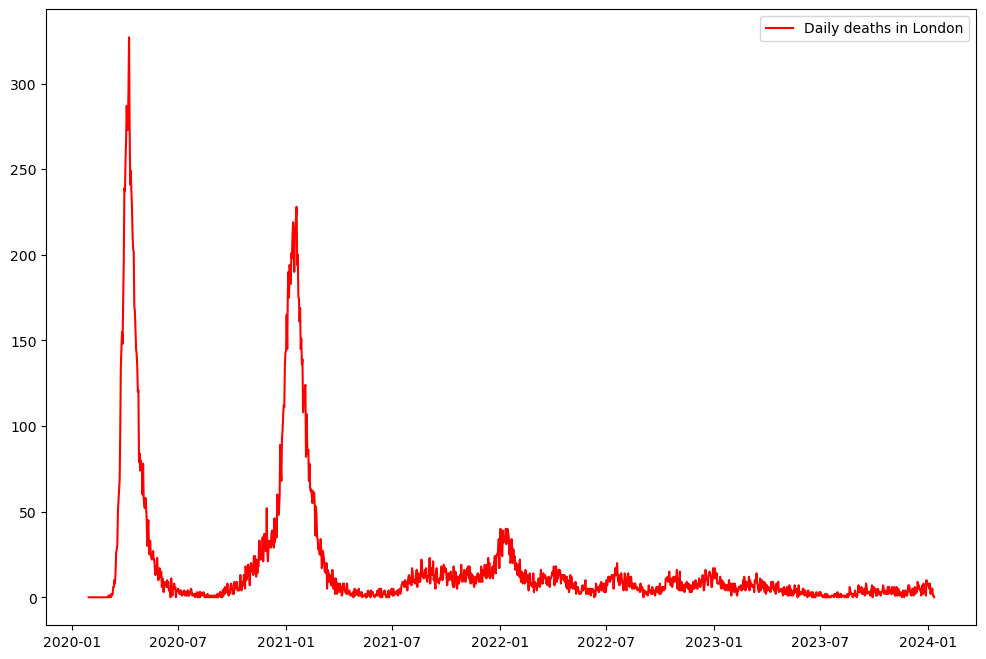

'\nAnswer: \nI think there are three periods of plateau here:\n\nAround July 2020 to around October 2020.\nAround April 2021 until December 2021, when another peak occurred.\nAfter the peak, it started to plateau around March 2022.\n'

In [28]:
#1. Aggregate the data
london_daily_deaths = regions_df[regions_df['Region'] == 'London']
#2. Plot the data
plt.figure(figsize=(12, 8))
plt.plot(london_daily_deaths['date'], london_daily_deaths['daily_deaths'], label='Daily deaths in London', color='r')
plt.legend()
plt.show()
#3. Question: Is there a period in time in which the deaths plateaued?
"""
Answer: 
I think there are three periods of plateau here:

Around July 2020 to around October 2020.
Around April 2021 until December 2021, when another peak occurred.
After the peak, it started to plateau around March 2022.
"""

### Task 10

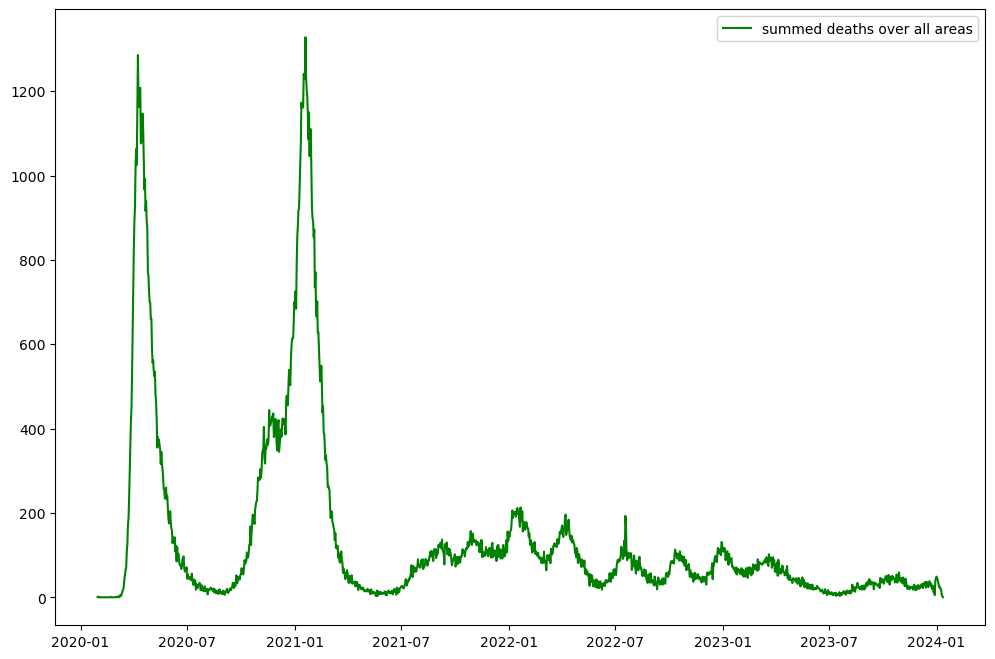

'\nThe overall trend in London largely reflects the all areas, but there are some differences:\n\nDuring the second peak, the number of deaths in all areas was significantly higher.\nAfter March 2022, London showed a more stable pattern, but consider trend of all areas still exhibited noticeable fluctuations.\n'

In [30]:
#1. Aggregate the data
sum_regions_deaths =regions_df.groupby("date")["daily_deaths"].sum().reset_index() # since sum_regions_deaths is series , add .reset_index() turn back to datafrane to avoid error in plot

#2. Plot the data.
plt.figure(figsize=(12, 8))
plt.plot(sum_regions_deaths['date'], sum_regions_deaths['daily_deaths'], label='summed deaths over all areas', color='g')
plt.legend()
plt.show()
#3.  Question: How does the pattern seen in London hold country-wide?
'''
The overall trend in London largely reflects the all areas, but there are some differences:

During the second peak, the number of deaths in all areas was significantly higher.
After March 2022, London showed a more stable pattern, but consider trend of all areas still exhibited noticeable fluctuations.
'''

### Task 11

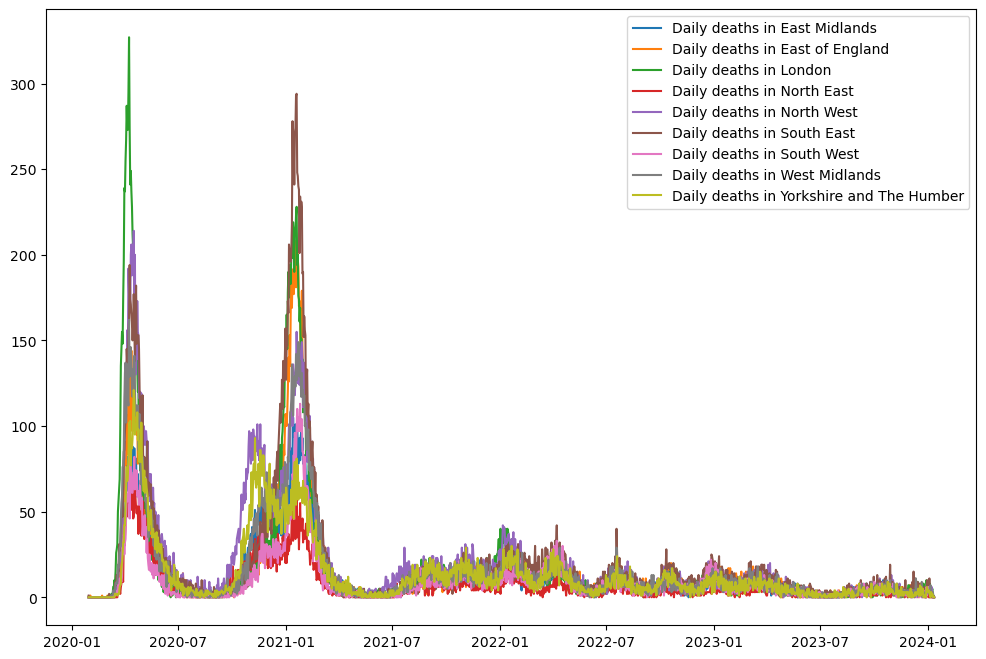

'\nThe line patterns for each region are very similar:\n\nThere were peaks in March-April 2020 and January 2021.\nAfter 2022, the trends became very stable across all regions, sonetimes exhibited fluctuations.\n'

In [32]:
# 1. Aggregate the data
regions = regions_df.groupby('Region')
# 2. Plot the data.
plt.figure(figsize=(12, 8))
for region, group_data in regions:
    plt.plot(group_data['date'], group_data['daily_deaths'], label=f'Daily deaths in {region}')
plt.legend()
plt.show()

#3. Question: What patterns do all nations/regions share?
'''
The line patterns for each region are very similar:

There were peaks in March-April 2020 and January 2021.
After 2022, the trends became very stable across all regions, sonetimes exhibited fluctuations.
'''

### Task 12

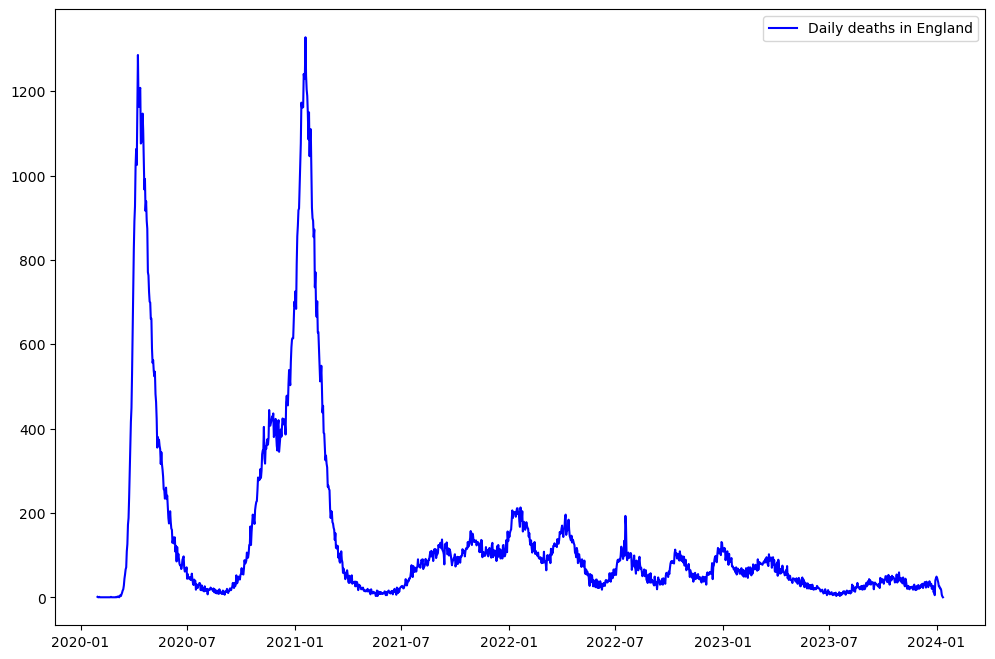

'\nYes, there is a noticeable period where the ongoing trend is broken in January 2021\nThis marks a significant peak in daily deaths, sharply deviating from the declining trend seen after the first peak in March 2020.\n'

In [42]:
# 1. Aggregate the data
# england_df contain all england daily deaths

# 2. Plot the data.
plt.figure(figsize=(12, 8))
plt.plot(england_df["date"], england_df["daily_deaths"], label="Daily deaths in England", color="b")
plt.legend()
plt.show()
#3. Question: Is there a noticeable period in time when the ongoing trend is broken? When?
'''
Yes, there is a noticeable period where the ongoing trend is broken in January 2021
This marks a significant peak in daily deaths, sharply deviating from the declining trend seen after the first peak in March 2020.
'''

### Task 13

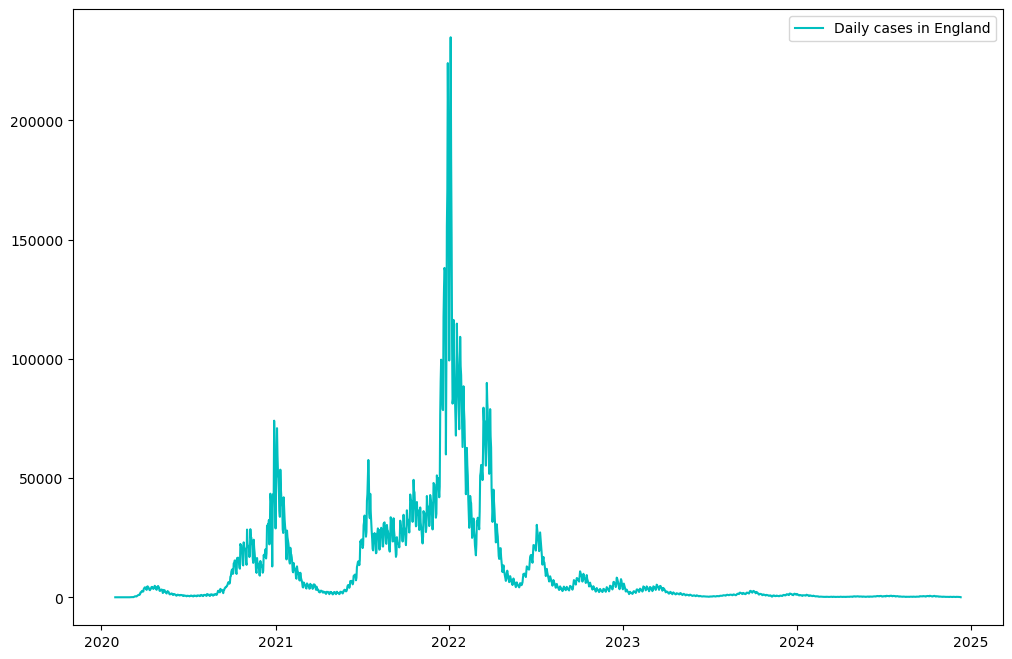

'\nThe two peaks in daily deaths in 2020 and 2021 also appear in the daily cases chart.\nInterestingly, in the first three months of 2022, \ndaily cases were even higher than during the previous two peaks, \nbut the number of deaths during this period was significantly lower than before.\n'

In [46]:
# 1. Aggregate the data
# england_df contain all england daily deaths

# 2. Plot the data.
plt.figure(figsize=(12, 8))
plt.plot(england_df["date"], england_df["daily_cases"], label="Daily cases in England", color="c")
plt.legend()
plt.show()

#3. Question: Based on the data and plot from the last question, is there any similarity between trends in daily cases and daily deaths?
'''
The two peaks in daily deaths in 2020 and 2021 also appear in the daily cases chart.
Interestingly, in the first three months of 2022, 
daily cases were even higher than during the previous two peaks, 
but the number of deaths during this period was significantly lower than before.
'''